# Векторизация текста и кластеризация слов

**Цель:** проанализировать роман М.А. Булгакова "Мастер и Маргарита", визуализировать векторное пространство слов, провести кластеризацию самых частотных слов.

## 1. Загрузка и предобработка текста

In [ ]:
!pip install pymorphy2

In [ ]:
import numpy as np
import requests
import nltk
from nltk.tokenize import sent_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
import pymorphy2
from collections import Counter
from gensim.models.word2vec import Word2Vec
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
# ссылка на роман "Мастер и Маргарита"
url = 'https://raw.githubusercontent.com/nevmenandr/word2vec-russian-novels/master/books_before/MasterAndMargarita.txt'

In [ ]:
# загрузка текста
resp = requests.get(url)
text = resp.text

print(text[-100:])

безносый убийца Гестаса, ни жестокий пятый прокуратор Иудеи всадник Понтийский Пилат.

1929 – 1940




In [ ]:
# предобработка текста
text = text.lower()
sents = sent_tokenize(text)
print('Количество предложений:', len(sents))

Количество предложений: 8762


In [ ]:
tokenizer = RegexpTokenizer('\w+')
sents_tokenize = [tokenizer.tokenize(sent) for sent in sents]
words = [item for sent in  sents_tokenize for item in sent]

print('Количество слов:', len(words),
      '\nКоличество уникальных слов:', len(set(words)))


Количество слов: 114069 
Количество уникальных слов: 23714


In [ ]:
# исключаем стоп-слова
stopwords_ru = stopwords.words('russian')
sents_tokenize = [[word for word in text_cur if word not in stopwords_ru] for text_cur in sents_tokenize]
words = [item for sent in  sents_tokenize for item in sent]

print('Количество слов:', len(words),
      '\nКоличество уникальных слов:', len(set(words)))

Количество слов: 70809 
Количество уникальных слов: 23563


In [ ]:
# лемматизация
morph = pymorphy2.MorphAnalyzer()
sents_tokenize = [[morph.normal_forms(word)[0] for word in text_cur] for text_cur in sents_tokenize]
words = [item for sent in  sents_tokenize for item in sent]

print('Количество слов:', len(words),
      '\nКоличество уникальных слов:', len(set(words)))

Количество слов: 70809 
Количество уникальных слов: 10966


In [ ]:
# создание словаря
word_dict = Counter(words)
print('Наиболее часто встречающиеся слова\n')
word_dict.most_common()[:20]

Наиболее часто встречающиеся слова



[('это', 687),
 ('маргарита', 621),
 ('сказать', 469),
 ('рука', 368),
 ('свой', 363),
 ('который', 354),
 ('иван', 353),
 ('человек', 349),
 ('глаз', 346),
 ('ответить', 294),
 ('один', 280),
 ('стать', 271),
 ('прокуратор', 267),
 ('говорить', 266),
 ('воланд', 265),
 ('какой', 258),
 ('знать', 254),
 ('голова', 245),
 ('кот', 233),
 ('лицо', 230)]

## 2. Обучение модели Word2Vec

In [ ]:
model = Word2Vec(vector_size=100, window=2, min_count=3, workers=4)
model.build_vocab(sents_tokenize)
model.train(sents_tokenize, total_examples=model.corpus_count, epochs=100)

(5983781, 7080900)

## 3. Анализ результатов

In [ ]:
print('Число примеров в обучающей выборке:', model.corpus_count)

Число примеров в обучающей выборке: 8762


In [ ]:
print('Количество слов в модели:', len(model.wv.key_to_index))

Количество слов в модели: 4652


In [ ]:
'кот' in model.wv.key_to_index

True

In [ ]:
# похожести слов
model.wv.similarity('кот', 'бегемот')

0.22450444

In [ ]:
model.wv.similarity('автор', 'мастер')

0.21636428

In [ ]:
model.wv.similarity('маргарита', 'ведьма')

0.3640309

In [ ]:
model.wv.similarity('лысый', 'гора')

0.6033914

In [ ]:
# самые похожие
model.wv.most_similar('прокуратор')

[('арестант', 0.4933801591396332),
 ('жестокий', 0.4682883620262146),
 ('пилат', 0.43644005060195923),
 ('игемона', 0.4167969822883606),
 ('измерение', 0.4106195867061615),
 ('крысобой', 0.38754433393478394),
 ('первосвященник', 0.3871768116950989),
 ('секретарь', 0.38423028588294983),
 ('теряться', 0.37899044156074524),
 ('иудей', 0.3758799135684967)]

In [ ]:
model.wv.most_similar('кот')

[('котёнок', 0.36355072259902954),
 ('плевать', 0.36271214485168457),
 ('боров', 0.3517495095729828),
 ('дерзить', 0.34976726770401),
 ('вред', 0.34915846586227417),
 ('шрам', 0.34637704491615295),
 ('нарочно', 0.34574198722839355),
 ('маузер', 0.3456230163574219),
 ('поклон', 0.34476783871650696),
 ('страдальчески', 0.3407050371170044)]

In [ ]:
model.wv.most_similar('гора')

[('лысый', 0.6033914089202881),
 ('оцепить', 0.5729402303695679),
 ('прокатиться', 0.49018406867980957),
 ('дева', 0.4857146143913269),
 ('север', 0.4659782946109772),
 ('череп', 0.456246018409729),
 ('яффский', 0.4544488787651062),
 ('уступ', 0.45401352643966675),
 ('западный', 0.4533407986164093),
 ('чертовый', 0.4416390657424927)]

In [ ]:
# арифметика
model.wv.most_similar(positive=['маргарита'], negative=['ведьма'])[:10]

[('внезапно', 0.33705589175224304),
 ('веко', 0.31056877970695496),
 ('собственный', 0.30987656116485596),
 ('окинуть', 0.307183176279068),
 ('череп', 0.27979084849357605),
 ('экономист', 0.2796928882598877),
 ('сжимать', 0.27950161695480347),
 ('присесть', 0.27925094962120056),
 ('сжать', 0.2728174924850464),
 ('повести', 0.2638075053691864)]

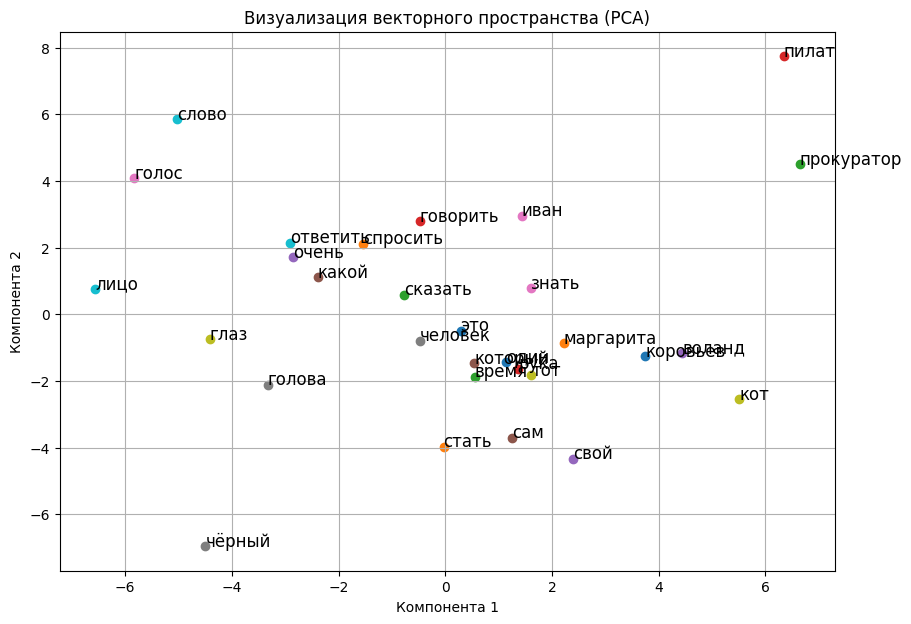

In [ ]:
words = [w[0] for w in word_dict.most_common()[:30]]

# проверка наличия слов в модели и получение их векторов
word_vectors = []
valid_words = []
for word in words:
    if word in model.wv:
        word_vectors.append(model.wv[word])
        valid_words.append(word)

word_vectors = np.array(word_vectors)

# снижение размерности с использованием PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(word_vectors)

# визуализация
plt.figure(figsize=(10, 7))
for i, word in enumerate(valid_words):
    plt.scatter(pca_result[i, 0], pca_result[i, 1])
    plt.annotate(word, (pca_result[i, 0], pca_result[i, 1]), fontsize=12)

plt.title('Визуализация векторного пространства (PCA)')
plt.xlabel('Компонента 1')
plt.ylabel('Компонента 2')
plt.grid()
plt.show()

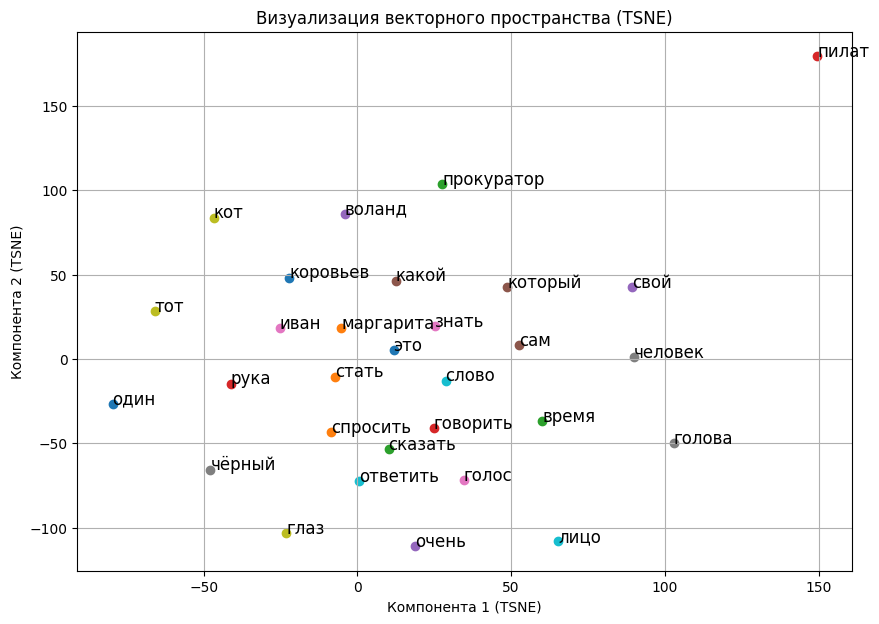

In [ ]:
# снижение размерности с использованием t-SNE
tsne = TSNE(n_components=2, perplexity=5, n_iter=1000, random_state=42)
tsne_result = tsne.fit_transform(word_vectors)

# визуализация
plt.figure(figsize=(10, 7))
for i, word in enumerate(valid_words):
    plt.scatter(tsne_result[i, 0], tsne_result[i, 1])
    plt.annotate(word, (tsne_result[i, 0], tsne_result[i, 1]), fontsize=12)
plt.title('Визуализация векторного пространства (TSNE)')
plt.xlabel('Компонента 1 (TSNE)')
plt.ylabel('Компонента 2 (TSNE)')
plt.grid()
plt.show()

**Вывод:**

Для наших целей более эффективным методом оказался метод PCA. После него лучше всего визуализировались вектора слов.

Мы видим, что модель хорошо захватывает семантические связи у наиболее часто встречающихся слов.

Например, близко располагаются слова:
- говорить, спросить, сказать, ответить;
- Пилат и прокуратор;
- голос и слово;
- глаз, голова, лицо;
- Маргарита, кот, Коровьев, Воланд.


## 4. Кластеризация слов

### 4.1. Кластеризация 30 самых частотных слов на 2 кластера

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
<ipython-input-25-1bcf05e6b720>:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', n_clusters)


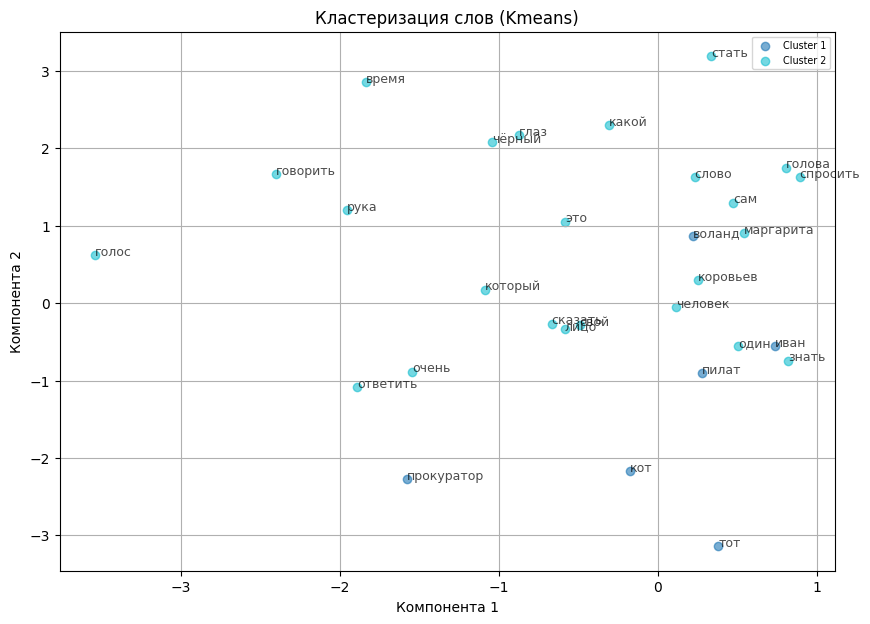

In [ ]:
# количество кластеров
n_clusters = 2

# модель KMeans
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(word_vectors)
# метки
labels = kmeans.labels_

# визуализация кластеров

plt.figure(figsize=(10, 7))

colors = plt.cm.get_cmap('tab10', n_clusters)
for i in range(n_clusters):
    cluster_indices = np.where(labels == i)
    plt.scatter(word_vectors[cluster_indices, 0],
                word_vectors[cluster_indices, 1],
                label=f'Cluster {i+1}',
                color=colors(i),
                alpha=0.6)

for i, word in enumerate(valid_words):
    plt.annotate(word, (word_vectors[i, 0], word_vectors[i, 1]), fontsize=9, alpha=0.7)

plt.title('Кластеризация слов (Kmeans)')
plt.xlabel('Компонента 1')
plt.ylabel('Компонента 2')
plt.legend(fontsize='x-small')
plt.grid()
plt.show()

### 4.2. Кластеризация 100 самых частотных слов на 3 кластера

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
<ipython-input-26-c7a1b50bf949>:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', n_clusters)


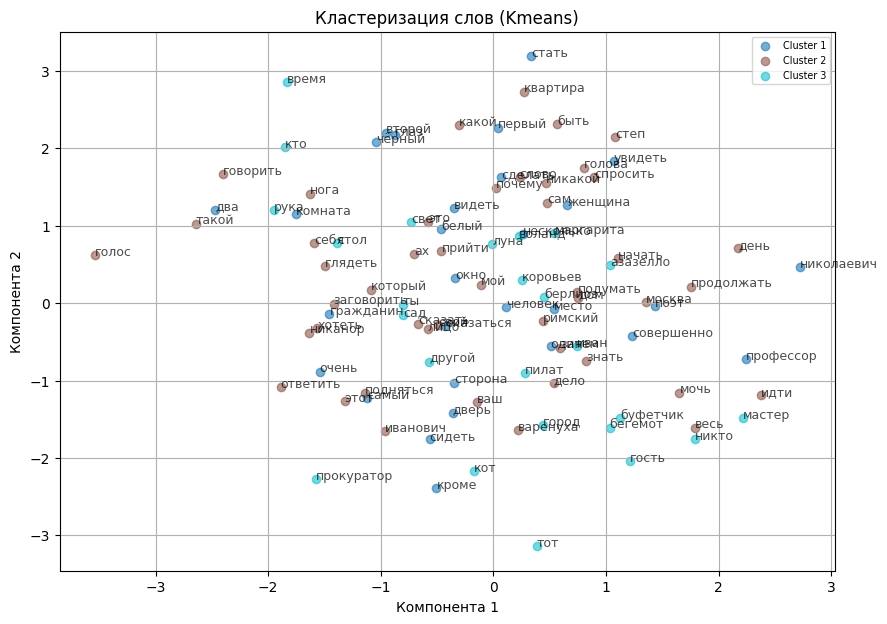

In [ ]:
words = [w[0] for w in word_dict.most_common()[:100]]

# проверка наличия слов в модели и получение их векторов
word_vectors = []
valid_words = []
for word in words:
    if word in model.wv:
        word_vectors.append(model.wv[word])
        valid_words.append(word)

word_vectors = np.array(word_vectors)

# количество кластеров
n_clusters = 3

# модель KMeans
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(word_vectors)
# метки
labels = kmeans.labels_

# визуализация кластеров

plt.figure(figsize=(10, 7))

colors = plt.cm.get_cmap('tab10', n_clusters)
for i in range(n_clusters):
    cluster_indices = np.where(labels == i)
    plt.scatter(word_vectors[cluster_indices, 0],
                word_vectors[cluster_indices, 1],
                label=f'Cluster {i+1}',
                color=colors(i),
                alpha=0.6)

for i, word in enumerate(valid_words):
    plt.annotate(word, (word_vectors[i, 0], word_vectors[i, 1]), fontsize=9, alpha=0.7)

plt.title('Кластеризация слов (Kmeans)')
plt.xlabel('Компонента 1')
plt.ylabel('Компонента 2')
plt.legend(fontsize='x-small')
plt.grid()
plt.show()

**Вывод:**

Здесь я попробовала разные комбинации количества кластрев и количества слов. Наиболее интересными показались:
- кластеризация 30 самых частотных слов на 2 кластера:
здесь действующие лица отделились от других слов;
- кластеризация 100 самых частотных слов на 3 кластера: здесь в кластеры выделились действующие лица (кластер 3), люди и предметы (кластер 1), преимущественно действия (кластер 2).